In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import descartes
from shapely.geometry import Polygon
import geopandas as gpd
import os.path
from PIL import Image
import rasterio

## global variables
CLIP = False
INTERSEC = True



In [53]:
if(CLIP):
    # read in all of your files #TODO make sure these match your file path
    os.chdir("/Users/aminaly/Box Sync/mountain_biodiversity")

    kba = gpd.read_file(os.getcwd() + "/data/KBA/KBA2020/KBAsGlobal_2020_September_02_POL.shp")
    wdpa = gpd.read_file(os.getcwd() + "/data/WDPA/WDPA_May2021_Public_shp/WDPA_May2021_Public/WDPA_May2021_Public_shp-polygons.shp")
    gmba = gpd.read_file(os.getcwd() + "/data/GMBA/GMBA_Inventory_V2_210420_GME/GMBA_Inventory_V2_210420_GME.shp")
    
    #sample 25 random countries and those will be what we use to subset everything
    world = gpd.read_file(os.getcwd() + "/data/World/world_shp/world.shp")
    world_sample = world.sample(25)
    wrld_cntries = world_sample.CNTRY_NAME.unique()
    wrld_cntries = set(np.concatenate((wrld_cntries, ['Switzerland', 'Germany'])))
    
    ## Using the countries picked out in world_sample, get 
    kba_clipped = kba[kba['Country'].isin(wrld_cntries)]
    #kba_clipped = gpd.overlay(kba, world_sample, how="intersection")

    ## Clip the countries using a random sample of ISO3 codes
    wdpa_clipped = wdpa[wdpa['ISO3'].isin(kba_clipped.ISO3.unique())]
    #filter out the ones wdpa didn't have
    kba_clipped = kba_clipped[kba_clipped['ISO3'].isin(wdpa_clipped.ISO3.unique())]

    ## Clip the mountain ranges to only include those that exist in the countries included above
    #cut out any of the countries the two above didn't pick up
    world_sample = world_sample[world_sample['CNTRY_NAME'].isin(kba_clipped['Country'].unique())] 
    gmba_clipped = gpd.overlay(gmba, world_sample, how="intersection")
    
    #Once we've clipped them, save them out as shapefiles
    kba_clipped.to_file(os.getcwd() + "/data/KBA/KBA2020/clipped_KBAsGlobal_2020_September_02_POL.shp", 
                        driver='ESRI Shapefile')

    wdpa_clipped.to_file(os.getcwd() + 
                         "/data/WDPA/WDPA_May2021_Public_shp/WDPA_May2021_Public/clipped_WDPA_May2021_Public_shp-polygons.shp",
                       driver='ESRI Shapefile')

    gmba_clipped.to_file(os.getcwd() + "/data/GMBA/GMBA_Inventory_V2_210420_GME/clipped_GMBA_Inventory_V2_210420_GME.shp", 
                        driver='ESRI Shapefile')

In [74]:
if(INTERSEC):
    ## first we overlay pa and kba
    if(CLIP):
        wdpa_kba_clipped = gpd.overlay(wdpa_clipped, kba_clipped, how = "intersection")
    else: 
        wdpa_kba = gpd.overlay(wdpa, kba, how = "intersection")

In [68]:
wdpa_clip_kba.head()

{'init': 'epsg:4326'}

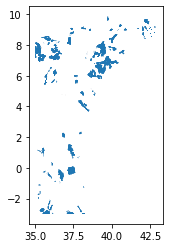

In [27]:
all_intersec = gpd.overlay(wdpa_clip_kba, gmba_clipped, how = "intersection")
all_intersec.plot()
all_intersec.to_file(os.getcwd() + "/data/wdpa_kba_gmba/wdpa_kba_gmba.shp", driver = 'ESRI Shapefile')

In [27]:
kba.head()

,SitRecID,Country,ISO3,NatName,IntName,SitArea,IbaStatus,KbaStatus,AzeStatus,AddedDate,ChangeDate,Source,DelTxt,DelGeom,Shape_Leng,Shape_Area,geometry
0,19,Andorra,AND,IBA D'Andorra,Pirineo de Andorra,47463,confirmed,None,None,2009-06-17,None,IBA Directory description used to define bound...,Political layer used to provide boundary data,Draft polygon,1.060533,0.052022,"POLYGON ((1.43992 42.60649, 1.45041 42.60597, ..."
1,35,Czechia,CZE,Sumava,Sumava mountains (Bohemian forest),97502,confirmed,None,None,2008-02-25,None,"CSO, 250208, following European updates by Rob...",None,Refined polygon,4.661308,0.119770,"POLYGON ((13.08431 49.24580, 13.08420 49.24598..."
2,36,Czechia,CZE,Trebonsko,Trebonsko (Trebon region),47375,confirmed,None,None,2008-02-25,None,"CSO, 250208, following European updates by Rob...",None,Refined polygon,2.253806,0.058261,"POLYGON ((14.74880 49.03006, 14.74882 49.02989..."
3,37,Czechia,CZE,DehtÃ¡r,DehtÃ¡r pond,352,confirmed,None,None,2008-02-25,None,"CSO, 250208, following European updates by Rob...",None,Refined polygon,0.106995,0.000433,"POLYGON ((14.29820 49.01458, 14.30028 49.01535..."
4,38,Czechia,CZE,Rezabinec,Rezabinec pond,111,confirmed,None,None,2008-02-25,None,"CSO, 250208, following European updates by Rob...",None,Refined polygon,0.054893,0.000137,"POLYGON ((14.09445 49.24842, 14.09404 49.24840..."


In [34]:
wdpa = gpd.read_file(os.getcwd() + "/data/WDPA/WDPA_May2021_Public_shp/WDPA_May2021_Public/WDPA_May2021_Public_shp-polygons.shp", driver='ESRI Shapefile')

In [50]:
np.concatenate((wrld_cntries, ['Switzerland', 'Germany', 'Tanzania']))


array(['Grenada', 'Christmas Island', 'Jamaica', 'Costa Rica', 'Anguilla',
       'Pacific Islands (Palau)', 'Ghana', 'Nepal', 'Cambodia',
       'Tanzania, United Republic of', 'British Virgin Islands',
       'Ivory Coast', 'Macedonia', 'Nicaragua', 'Guernsey',
       'Norfolk Island', 'Fiji', 'Algeria', 'El Salvador', 'Netherlands',
       'Angola', 'Malta', 'Bahrain', 'South Korea', 'Sudan',
       'Switzerland', 'Germany', 'Tanzania'], dtype=object)

,SitRecID,Country,ISO3,NatName,IntName,SitArea,IbaStatus,KbaStatus,AzeStatus,AddedDate,ChangeDate,Source,DelTxt,DelGeom,Shape_Leng,Shape_Area,geometry
1243,6000,Angola,AGO,Bicuare National Park,Bicuari National Park,772791,confirmed,None,None,2005-05-12,None,RSPB funded initiative to create polygon bound...,Digitized from national and continental scale ...,Draft polygon,3.190441,0.650258,"POLYGON ((14.94667 -15.69123, 14.93366 -15.690..."
1244,6001,Angola,AGO,Caconda,Caconda,81197,confirmed,None,None,2005-05-12,None,RSPB funded initiative to create polygon bound...,Digitized from national and continental scale ...,Draft polygon,0.939546,0.067845,"POLYGON ((15.09507 -13.55880, 15.14020 -13.562..."
1245,6002,Angola,AGO,Calandula (Quedas de Calandula),Calandula (Quedas de Calandula),57353,confirmed,None,None,2005-05-12,None,RSPB funded initiative to create polygon bound...,Digitized from national and continental scale ...,Draft polygon,0.856984,0.047160,"POLYGON ((15.91697 -8.86977, 15.98777 -8.87489..."
1246,6003,Angola,AGO,Camabatela,Camabatela,127631,confirmed,None,None,2005-05-12,None,RSPB funded initiative to create polygon bound...,Digitized from national and continental scale ...,Draft polygon,1.232335,0.104769,"POLYGON ((15.19397 -8.42705, 15.22506 -8.34408..."
1247,6004,Angola,AGO,Cameia National Park,Cameia National Park,1418510,confirmed,None,None,2005-05-12,None,RSPB funded initiative to create polygon bound...,Digitized from national and continental scale ...,Draft polygon,5.144447,1.177098,"POLYGON ((22.53249 -12.47255, 22.52663 -12.470..."
